# Определение закономерностей, влияющих на успешность игр

<a id='back-bullet'></a>

## Содержание
* [1. Загрузка и первичный анализ данных](#download-bullet)
* [2. Предобработка данных](#rework-bullet)
* [3. Исследовательский анализ данных](#analysis-bullet)
* [4. Формулировка и проверка гипотез](#hypothesis-bullet)
* [5. Заключение](#conclusion-bullet)

<a id='download-bullet'></a>

## 1. Загрузка и первичный анализ данных

In [1]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
#функция для первичного анализа данных
def full_info(data):
    print(' * ' * 20)
    print('Размер датафрейма:', data.shape)
    print('Количество дубликатов:', data.duplicated().sum())
    tab = pd.concat([data.dtypes, data.isna().sum(), data.isna().mean()*100], axis=1)
    tab.columns=['data_type', 'nan_count','nan_part, %']
    display(tab.sort_values(by='nan_count', ascending=False))    
    display(data.sample(5))
    display(data.describe())    
    print(' * ' * 20)

In [4]:
full_info(games)

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
Размер датафрейма: (16715, 11)
Количество дубликатов: 0


,data_type,nan_count,"nan_part, %"
Critic_Score,float64,8578,51.319174
Rating,object,6766,40.478612
User_Score,object,6701,40.089740
Year_of_Release,float64,269,1.609333
Name,object,2,0.011965
Genre,object,2,0.011965
Platform,object,0,0.000000
NA_sales,float64,0,0.000000
EU_sales,float64,0,0.000000
JP_sales,float64,0,0.000000


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
4382,NBA Live 2000,N64,1999.0,Sports,0.42,0.02,0.00,0.00,NaN,NaN,NaN
9249,Ape Escape Academy (jp sales),PSP,2004.0,Misc,0.00,0.00,0.13,0.00,NaN,NaN,NaN
3004,Zaidan Houjin Nippon Kanji Nouryoko Kentei Kyo...,DS,2006.0,Misc,0.00,0.00,0.67,0.00,NaN,NaN,NaN
7886,Taiko no Tatsujin: Wii U Version!,WiiU,2013.0,Misc,0.00,0.00,0.19,0.00,NaN,NaN,NaN
10766,MySims SkyHeroes,X360,2010.0,Action,0.09,0.00,0.00,0.01,56.0,5.5,E10+


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


* Для удобства необходимо привести назваание столбцов к нижнему регистру;
* Имеем пропуски для 6-ти признаков:  
critic_score, user_score - большое кол-во пропусков, причину выясним ниже. Пропуски заменим на среднюю оценку по игре. tbd - To Be Determined (пер. "предстоит определить") - будем считать пропуском;  
rating - большое кол-во пропусков, причину выясним ниже. Пропуски заменим на RP (ожидает оценки);
name, genre - вероятно, пропуски связаны с невнимательностью при заполнении формы, так как их кол-во мало. Необходимо удалить их из анализа, так как нет адекватной замены; 
year_of_Release - вероятно, пропуски связаны с невнимательностью при заполнении формы, так как их кол-во мало. Необходимо удалить их из анализа, так как нет адекватной замены;  
* Поменять тип данных: year_of_Release на int;

[Вернуться к содержанию](#back-bullet)

<a id='rework-bullet'></a>

## 2. Предобработка данных

### Приведение названий столбцов к нижнему регистру

In [5]:
new_columns = []
for column in games.columns:
    new_columns.append(column.lower())
games.columns = new_columns
games.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


### Обработка дубликатов

In [6]:
games[['name','platform']].duplicated().sum()

5

In [7]:
games = games.drop_duplicates(subset = ['name','platform']).reset_index(drop = True)
games[['name','platform']].duplicated().sum()

0

In [8]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Проанализировав возрастной рейтинг, пришли к следующему:   
K-A (старое название Е) = E; 
Только для взрослых (АО) и для взрослых (М) = М;
Для детей (Е) и для любого возраста (ЕС) = Е;

In [9]:
games['rating'] = games['rating'].replace('K-A', 'E')
games['rating'] = games['rating'].replace('AO', 'M')
games['rating'] = games['rating'].replace('EC', 'E')
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'RP'], dtype=object)

### Обработка пропусков

In [10]:
games.dropna(subset = {'name'}, inplace = True) #удаление строк без названия игры 
games.dropna(subset = {'year_of_release'}, inplace = True) #без года релиза
games['rating'] = games['rating'].fillna('RP') #замена nan на RP (ожидает оценки)

def score(name_score):
    games[name_score] = pd.to_numeric(games[name_score], errors='coerce')
    #используем метод to_numeric c типом ошибки coerce (недопустимый синтаксис = NaN)
    mean_user = games.groupby('name')[name_score].mean()
    mean_user = mean_user.dropna()
    for name in mean_user.index:
        games.loc[(games['name'] == name)  & (games[name_score].isnull()), name_score] = mean_user[name]
    games[name_score] = games[name_score].fillna('w/r') #w/r - without rating 
score('critic_score')
score('user_score')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16709
Data columns (total 11 columns):
name               16441 non-null object
platform           16441 non-null object
year_of_release    16441 non-null float64
genre              16441 non-null object
na_sales           16441 non-null float64
eu_sales           16441 non-null float64
jp_sales           16441 non-null float64
other_sales        16441 non-null float64
critic_score       16441 non-null object
user_score         16441 non-null object
rating             16441 non-null object
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


### Замена типов данных

In [11]:
games['year_of_release'] = games['year_of_release'].astype(np.int64)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16709
Data columns (total 11 columns):
name               16441 non-null object
platform           16441 non-null object
year_of_release    16441 non-null int64
genre              16441 non-null object
na_sales           16441 non-null float64
eu_sales           16441 non-null float64
jp_sales           16441 non-null float64
other_sales        16441 non-null float64
critic_score       16441 non-null object
user_score         16441 non-null object
rating             16441 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 1.5+ MB


### Создание столбца общих продаж

In [12]:
games['sum_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis = 1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,w/r,w/r,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,w/r,w/r,RP,31.38


[Вернуться к содержанию](#back-bullet)

<a id='analysis-bullet'></a>

## 3. Исследовательский анализ данных

### Зависимость количества выпущенных игр от года релиза

,сount_game
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


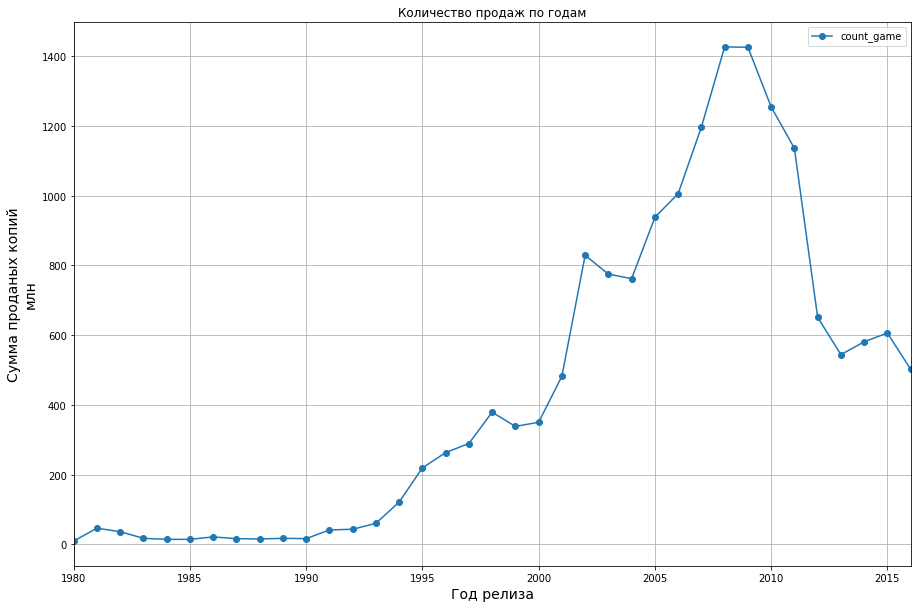

In [13]:
year = games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
year.columns = ['сount_game']
year.plot(grid = True, style = 'o-', figsize = (15, 10))
plt.xlabel("Год релиза", fontsize=14)
plt.ylabel("Сумма проданых копий\nмлн", fontsize=14)
plt.title('Количество продаж по годам')

year

**Вывод:** пик продаж пришёлся на 2008 - 2009 годы, что вероятно связано с большим кол-вом пиков популярности новых платформ

### Зависимость продаж игр от платформы

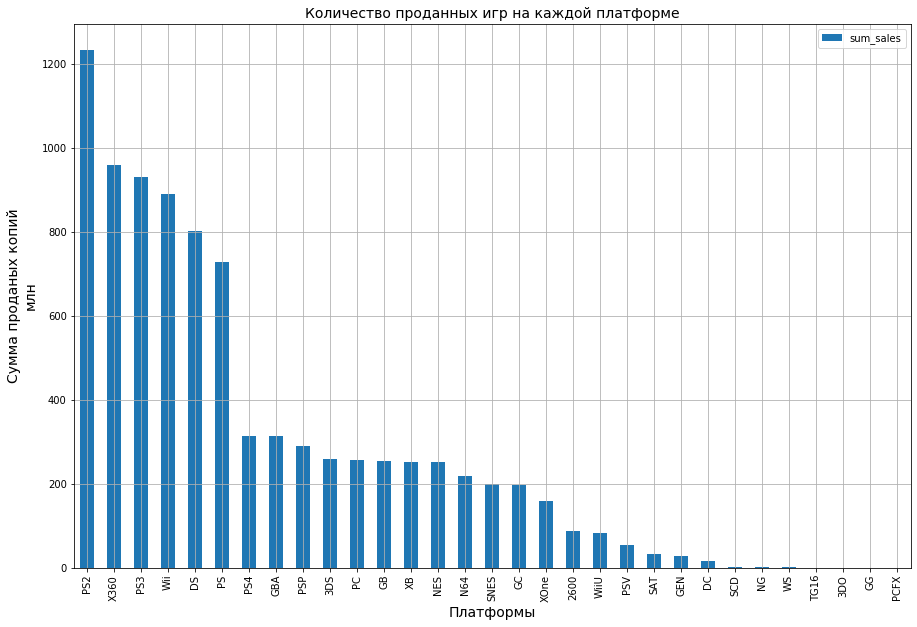

In [14]:
platform_sales = games.pivot_table(index = 'platform', values = 'sum_sales', aggfunc = 'sum')
platform_sales = platform_sales.sort_values(by = 'sum_sales', ascending = False)
platform_sales.plot(grid = True, style = 'o', figsize = (15, 10), kind= 'bar', subplots = True)
plt.xlabel("Платформы", fontsize=14)
plt.ylabel("Сумма проданых копий\nмлн", fontsize=14)
plt.title('Количество проданных игр на каждой платформе', fontsize=14)
platform_sales = platform_sales.head(20)

Выбираем 20 самых популярных платформ: от PS2 до WiiU. Для удобства анализа сделаем два графика: топ-10 и 11-20.

Text(0.5, 1.0, 'Количество проданных игр в год в зависимости от платформы')

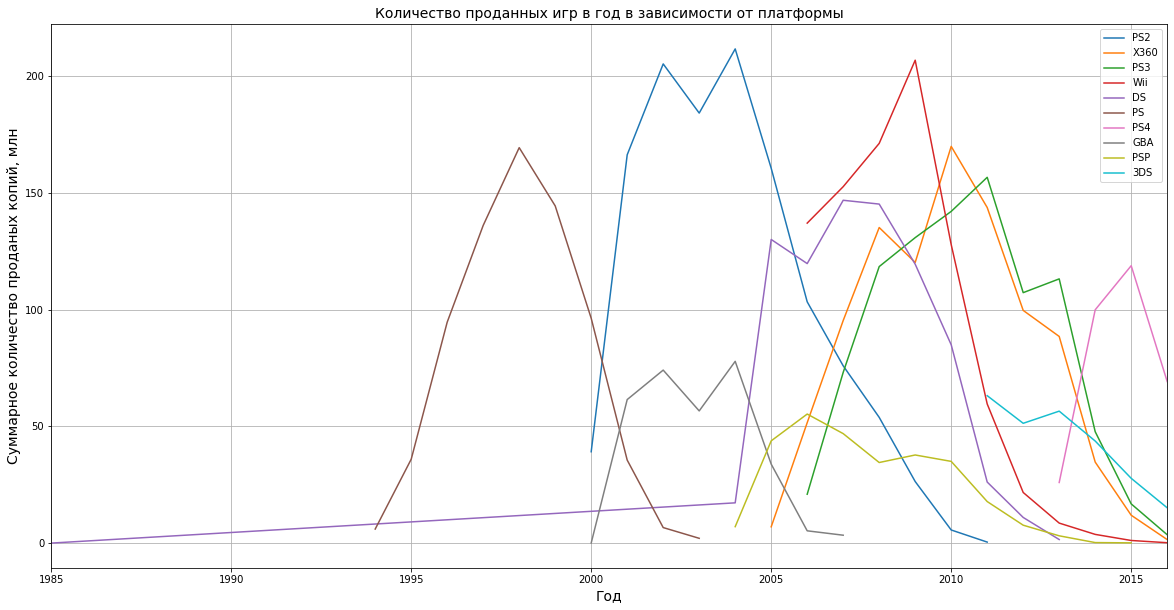

In [15]:
axis = games[games['platform'] == 'PS2'].pivot_table(index = 'year_of_release', values = 'sum_sales', aggfunc = 'sum').plot(y = 'sum_sales',grid = True, style = '-', label = 'PS2', figsize = (20, 10), legend = True)
for i in platform_sales.index[1:10]:
    games[games['platform'] == i].pivot_table(index = 'year_of_release', values = 'sum_sales', aggfunc = 'sum').plot(y = 'sum_sales', grid = True, style = '-', label = i, ax = axis, legend = True)

plt.xlabel("Год", fontsize=14)
plt.ylabel("Суммарное количество проданых копий, млн", fontsize=14)
plt.title('Количество проданных игр в год в зависимости от платформы', fontsize=14)

Text(0.5, 1.0, 'Количество проданных игр в год, в зависимости от платформы')

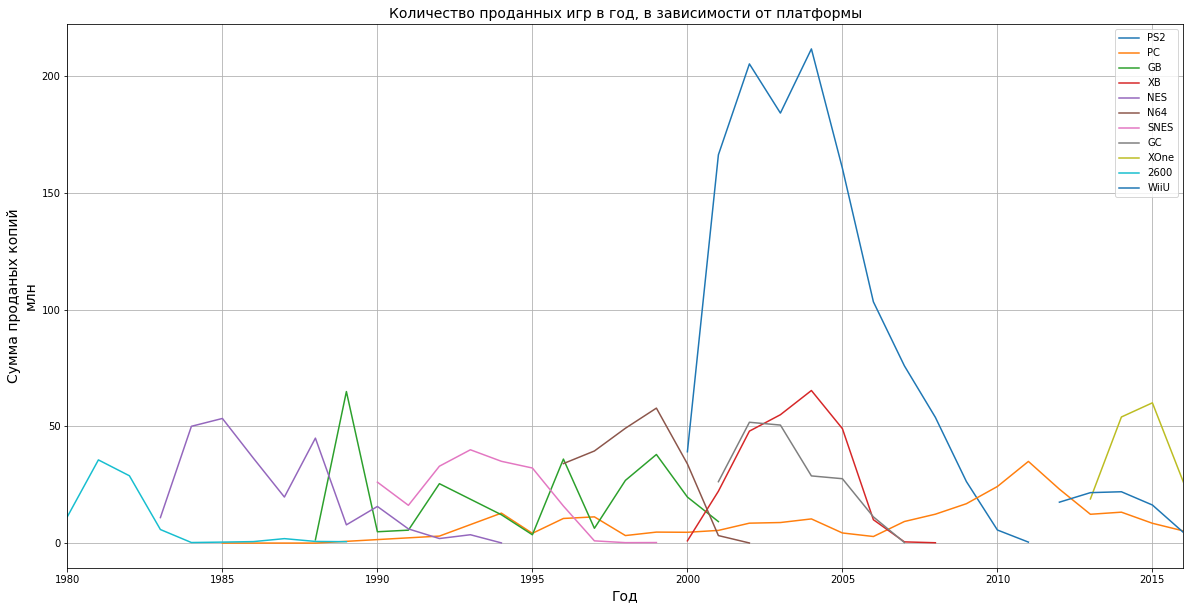

In [16]:
axis2 = games[games['platform'] == 'PS2'].pivot_table(index = 'year_of_release', values = 'sum_sales', aggfunc = 'sum').plot(y = 'sum_sales',grid = True, style = '-', label = 'PS2', figsize = (20, 10), legend = True)
for i in platform_sales.index[10:20]:
    games[games['platform'] == i].pivot_table(index = 'year_of_release', values = 'sum_sales', aggfunc = 'sum').plot(y = 'sum_sales', grid = True, style = '-', label = i, ax = axis2, legend = True)
    
plt.xlabel("Год", fontsize=14)
plt.ylabel("Сумма проданых копий\nмлн", fontsize=14)
plt.title('Количество проданных игр в год, в зависимости от платформы', fontsize=14)

**Вывод:** 

Этап 1: Начало активных продаж игр - 1994-1995 годы - связано с выходом первой PS. Пик популярности 1997 год.

Этап 2: Выход PS2 (пик популярности 2003-2005 года), также пик популярности в это время испытывали такие платформы как GBA, XB (общая популярность портативных приставок в то время). 

Этап 3: Выход нового поколения приставок, примерно в 2006-м году. Набирают популярность платформы PS3, X360, Wii, DS. 

Этап 4: Выход нового поколения приставок в 2013-м году. Что интересно, с 2015 года только PS4 и XOne набирали популярность (в сравнении с предыдущими годами).

Отдельно можно отметить стабильность PC платформы, которая имеет стабильные продажи на протяжении всего периода анализа.

**Актуальный период:** c 2013 (выход последнего поколения популярных платформ). 

**Актуальные платформы:** PS4 и XOne, которые набирают популярность. Также можно отнести к актульным платформы: 3DS, WiiU, X360, PS3, PC.

**Жизненный цикл платформы (в годах):**

In [17]:
live_games = games.pivot_table(index = 'platform', values = ['year_of_release'], aggfunc = ['min','max'])
live_games.columns = ['start_year','finish_year'] 
live_games['life'] = live_games['finish_year'] - live_games['start_year']
print('Средний срок жизни платформы:',round(live_games['life'].mean(),1))
print('Медиана срока жизни платформы:', int(live_games['life'].median()))
print('Минимальный срок жизни платформы:',live_games['life'].min())
print('Максимальный срок жизни платформы:',live_games['life'].max())

Средний срок жизни платформы: 7.6
Медиана срока жизни платформы: 6
Минимальный срок жизни платформы: 0
Максимальный срок жизни платформы: 31


In [18]:
live_games.sort_values(by = 'life', ascending = False)

,start_year,finish_year,life
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10
Wii,2006,2016,10


**Вывод:** ПК - долгожитель среди платформ. Это связано с тем, что можно бесконечно обновлять железо, при этом ПК так и останется ПК, что является одним из его преимуществ. С консолями так не получится, поэтому с выходом нового поколения старые модели морально устаривают и прекращают использоваться. Также можно увидеть платформы которые не выстрелили: TG16, PCFX и GG.

In [19]:
actual_games = games.query('year_of_release >= 2013')

In [20]:
platform = ['PS4','XOne','PC','WiiU','X360','PS3','3DS']

In [21]:
actual_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,w/r,w/r,RP,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,w/r,w/r,RP,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62


In [22]:
actual_games['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

Text(0.5, 0, 'Платформы')

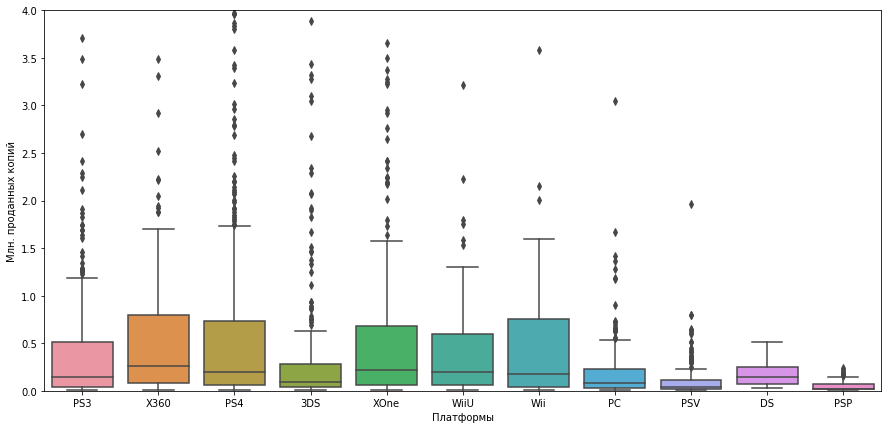

In [23]:
plt.figure(figsize=(15, 7))
boxplot = sns.boxplot(x = actual_games['platform'], y = actual_games['sum_sales']);
plt.ylim(0, 4)
plt.ylabel('Млн. проданных копий')
plt.xlabel('Платформы')

Text(0.5, 0, 'Платформы')

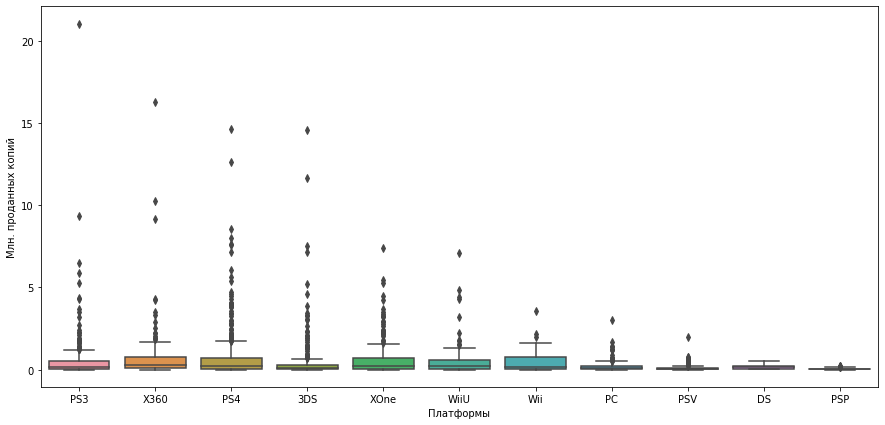

In [24]:
plt.figure(figsize=(15, 7))
boxplot = sns.boxplot(x = actual_games['platform'], y = actual_games['sum_sales']);
plt.ylabel('Млн. проданных копий')
plt.xlabel('Платформы')


**Вывод:** медианы у всех платформ примерно одинаковые (0.3 миллиона суммарных продаж). Основная часть игр находится в диапазоне до 1-го миллиона копий на платформу. Также существуют очень популярные игры на определенных платформах (выбросы).

### Влияние отзывов со стороны критиков и пользователей на продажи на примере платформы PS3.

In [25]:
PS3 = actual_games[(actual_games['platform'] == 'PS3')]
PS3.sort_values(by = 'sum_sales', ascending = False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71,2.6,M,9.36
126,FIFA 14,PS3,2013,Sports,0.78,4.24,0.07,1.37,86,4.3,E,6.46
149,The Last of Us,PS3,2013,Action,2.41,2.18,0.28,0.99,95,9.1,M,5.86
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,w/r,w/r,RP,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...
16180,Higurashi no Naku Koro ni Iki,PS3,2015,Action,0.00,0.00,0.01,0.00,w/r,w/r,RP,0.01
16142,Don Bradman Cricket 14,PS3,2014,Sports,0.00,0.01,0.00,0.00,73,6.9,E,0.01
15887,Rugby League Live 3,PS3,2015,Action,0.00,0.01,0.00,0.00,w/r,7.23333,RP,0.01
15876,Turbo: Super Stunt Squad,PS3,2013,Sports,0.00,0.01,0.00,0.00,38,4.53333,E,0.01


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Коэффициент Пирсона между отзывами критиков и продажами для PS3 равен 0.2932861836035928


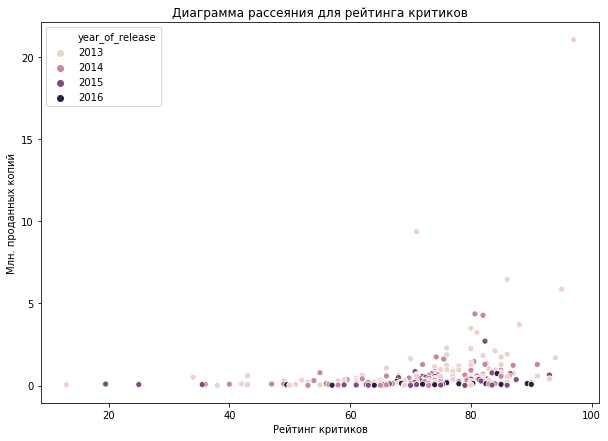

Коэффициент Пирсона между отзывами пользователей и продажами для PS3 равен 0.007552191267848472


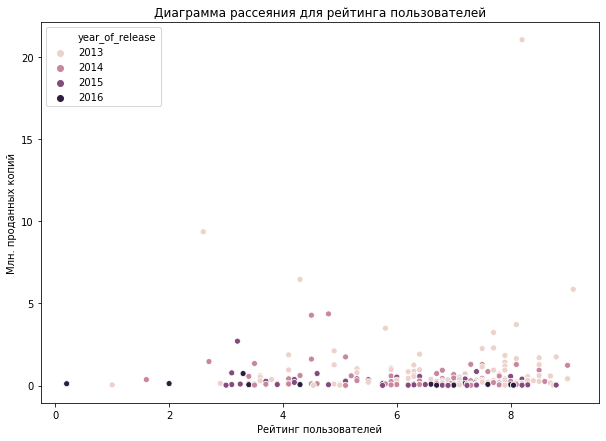

In [26]:
def correl(platform):
    table = actual_games.loc[(actual_games['platform'] == platform),:]
    table.loc[:,'user_score'] = pd.to_numeric(table.loc[:,'user_score'], errors = 'coerce')
    table.loc[:,'critic_score'] = pd.to_numeric(table.loc[:,'critic_score'], errors = 'coerce')
    print('Коэффициент Пирсона между отзывами критиков и продажами для',platform,'равен', table.loc[:,'critic_score'].corr(table.loc[:,'sum_sales']))
    plt.figure(figsize = (10, 7))
    sns.scatterplot(data = table, x = "critic_score", y = "sum_sales", hue = "year_of_release");
    plt.title('Диаграмма рассеяния для рейтинга критиков')
    plt.ylabel('Млн. проданных копий')
    plt.xlabel('Рейтинг критиков')
    plt.show()
    print('Коэффициент Пирсона между отзывами пользователей и продажами для',platform,'равен', table.loc[:,'user_score'].corr(table.loc[:,'sum_sales']))
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data = table, x = "user_score", y = "sum_sales", hue = "year_of_release");
    plt.title('Диаграмма рассеяния для рейтинга пользователей')
    plt.ylabel('Млн. проданных копий')
    plt.xlabel('Рейтинг пользователей')
    plt.show()
    print()
    
    
correl('PS3')

**Вывод:** обзоры критиков хоть и слабо, но сильнее влияют на продажи, чем отзывы пользователей (почти не влияют)

Коэффициент Пирсона между отзывами критиков и продажами для PS4 равен 0.3912652103818578


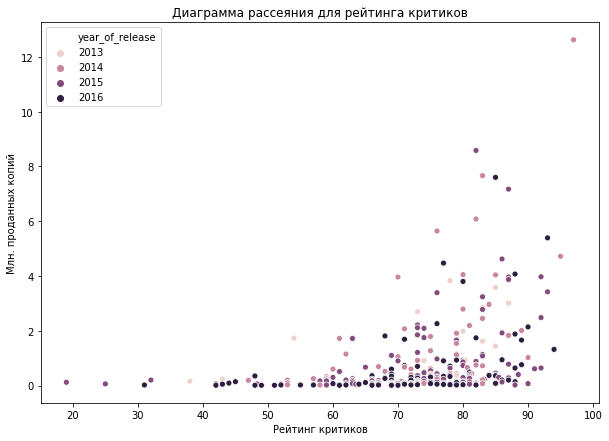

Коэффициент Пирсона между отзывами пользователей и продажами для PS4 равен -0.022937975931579375


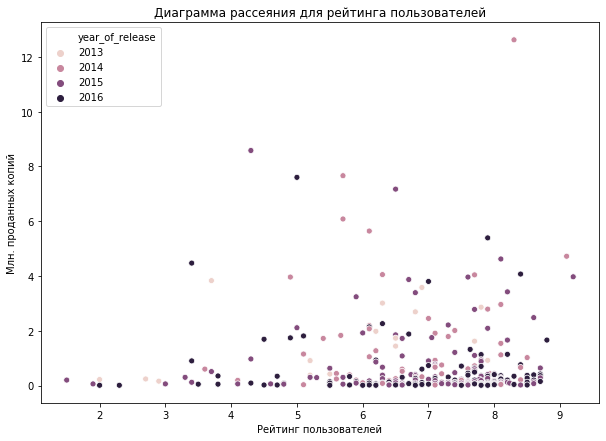


Коэффициент Пирсона между отзывами критиков и продажами для XOne равен 0.3751889589862616


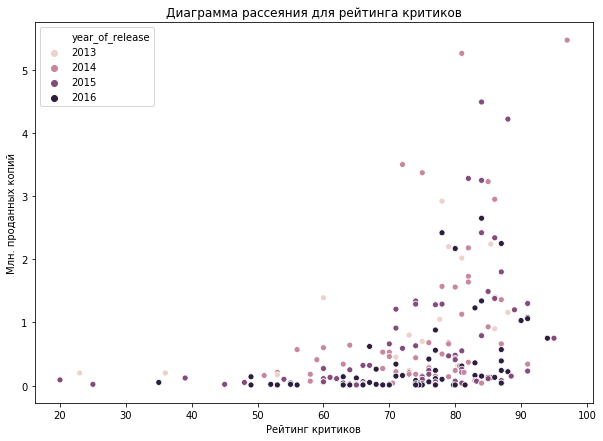

Коэффициент Пирсона между отзывами пользователей и продажами для XOne равен -0.09402739254121933


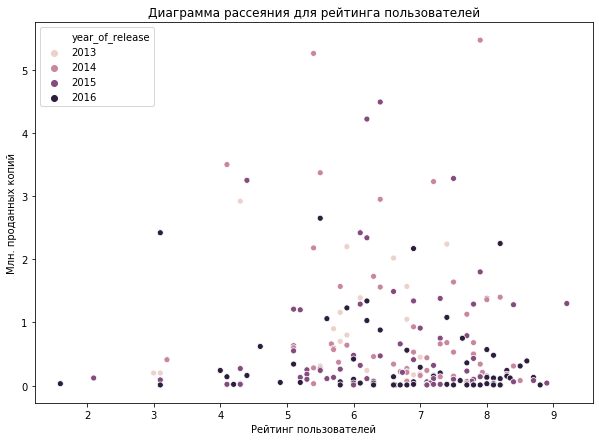


Коэффициент Пирсона между отзывами критиков и продажами для PC равен 0.19529196675360913


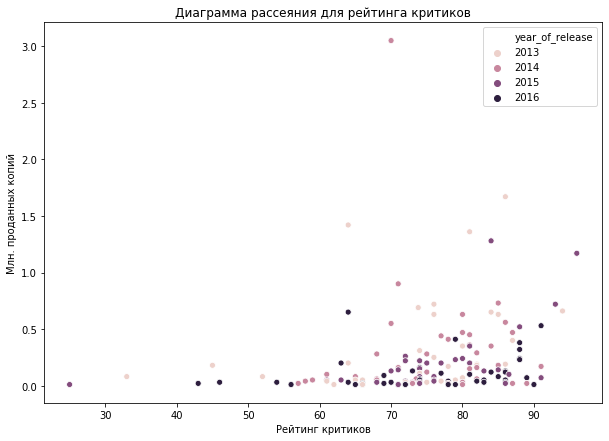

Коэффициент Пирсона между отзывами пользователей и продажами для PC равен -0.10655748811919938


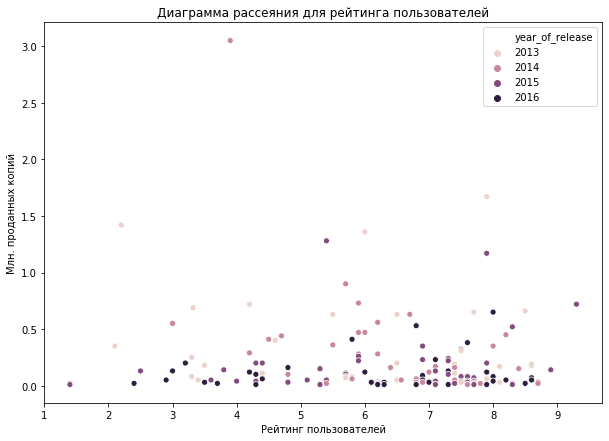


Коэффициент Пирсона между отзывами критиков и продажами для WiiU равен 0.38103784042578265


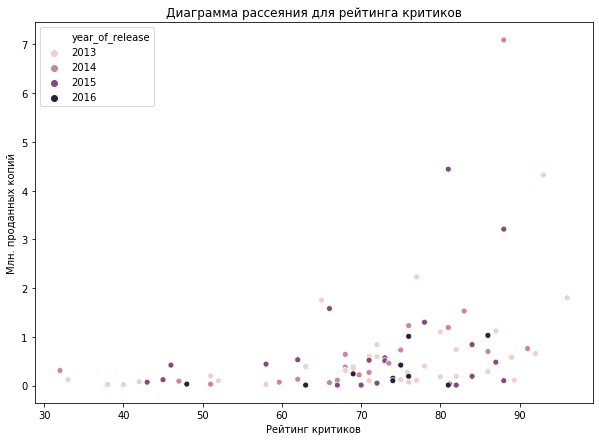

Коэффициент Пирсона между отзывами пользователей и продажами для WiiU равен 0.3988737240524272


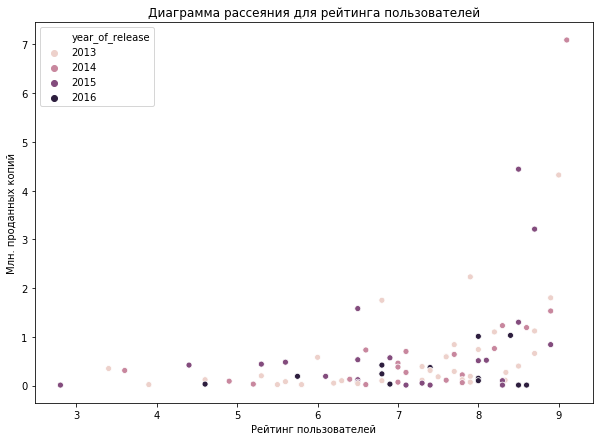


Коэффициент Пирсона между отзывами критиков и продажами для X360 равен 0.29328883691731533


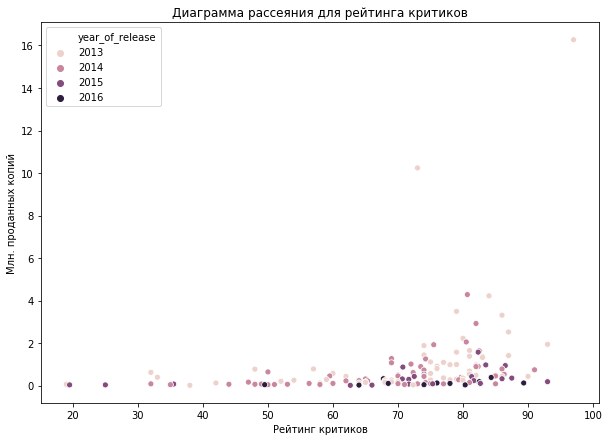

Коэффициент Пирсона между отзывами пользователей и продажами для X360 равен -0.01427694031279046


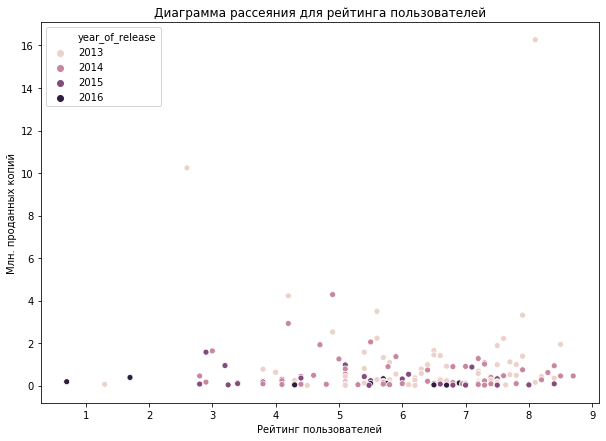


Коэффициент Пирсона между отзывами критиков и продажами для PS3 равен 0.2932861836035928


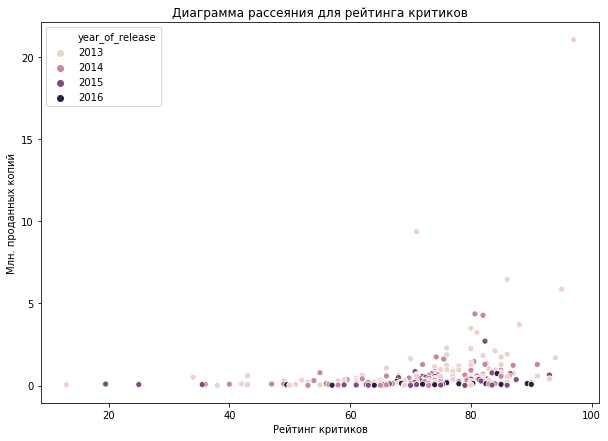

Коэффициент Пирсона между отзывами пользователей и продажами для PS3 равен 0.007552191267848472


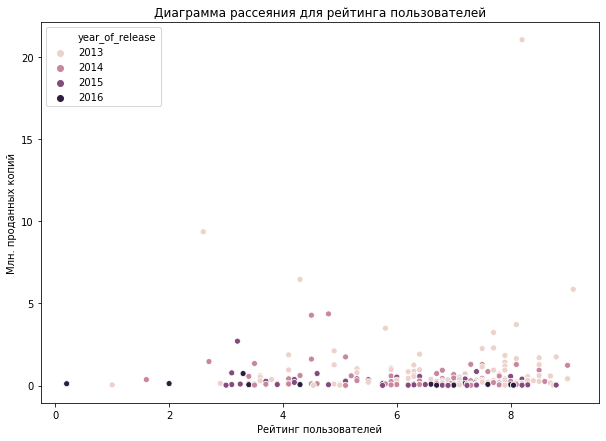


Коэффициент Пирсона между отзывами критиков и продажами для 3DS равен 0.3431975838675125


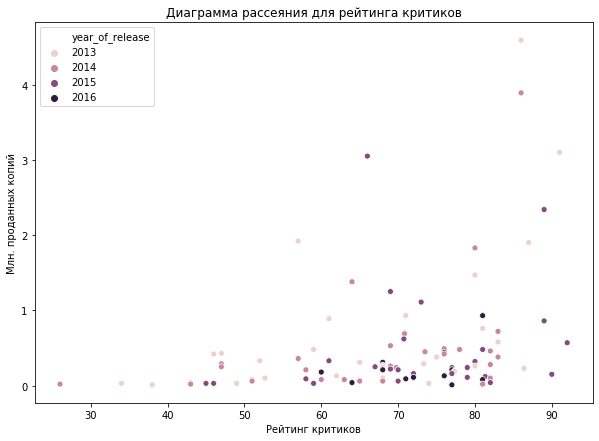

Коэффициент Пирсона между отзывами пользователей и продажами для 3DS равен 0.2873122626296861


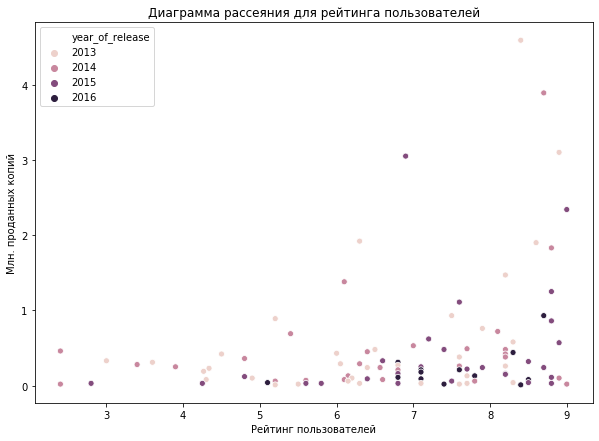

In [27]:
for i in platform:
    correl(i)

**Вывод:** коэффициенты Пирсона примерно равны для всех платформ

### Зависимость продаж игр от жанра

Text(0.5, 0, 'Жанры')

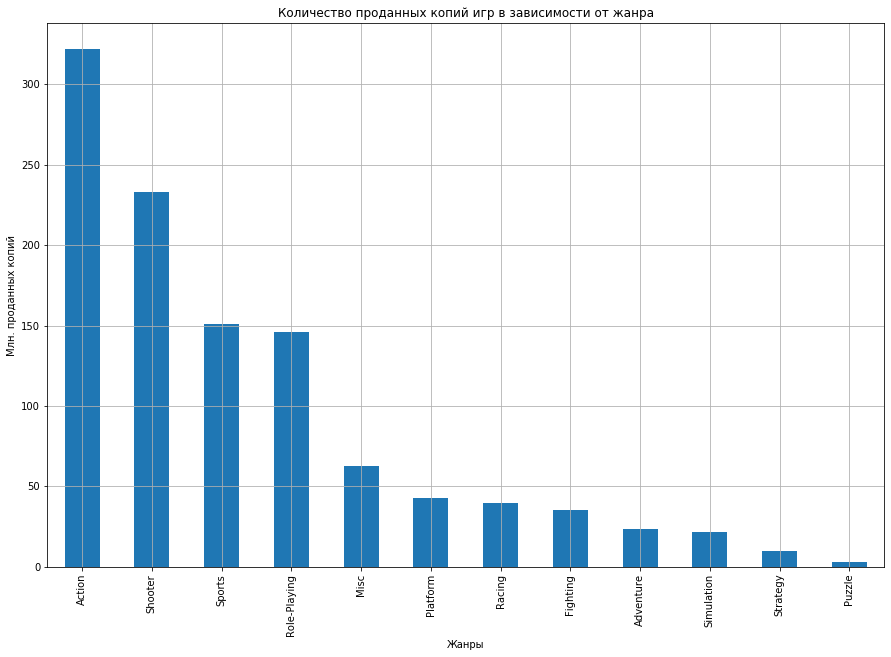

In [28]:
genre_games = actual_games.pivot_table(index = 'genre', values = ['sum_sales'], aggfunc = ['sum', 'count','median'])
genre_games.columns = ['sum_sales', 'amount_of_games','median_sales']
genre_games['sum_sales'].sort_values(ascending = False).plot(grid = True, figsize = (15, 10), kind= 'bar', subplots = True)
plt.title('Количество проданных копий игр в зависимости от жанра')
plt.ylabel('Млн. проданных копий')
plt.xlabel('Жанры')

**Вывод:** наиболее популярны жанры игр - экшн, шутеры, спортивные и ролевые. Вероятно, это связано с эмоциями и наибольшей вовлеченностью в процесс

Text(0.5, 0, 'Жанры')

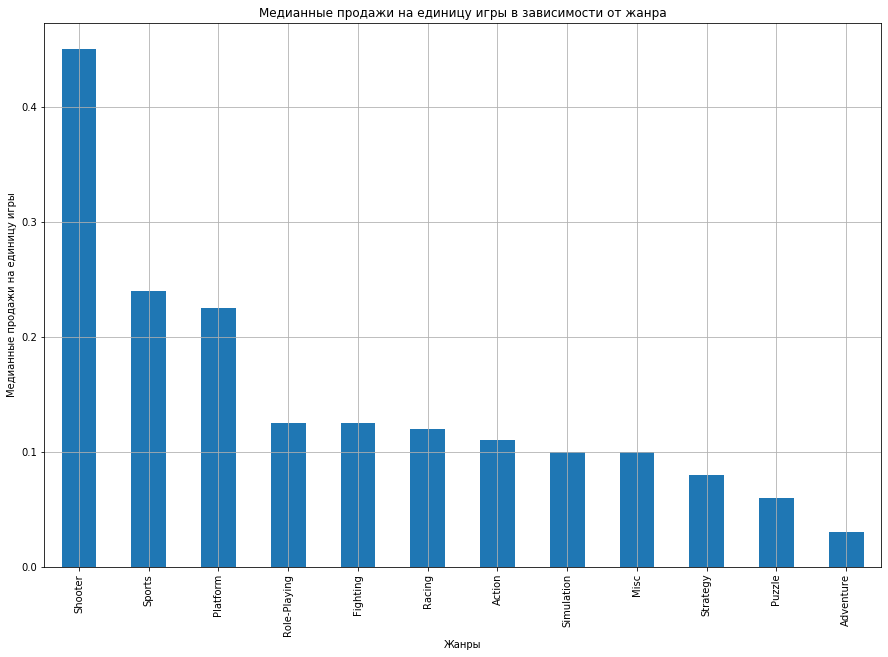

In [29]:
genre_games['median_sales'].sort_values(ascending = False).plot(grid = True, figsize = (15, 10), kind= 'bar', subplots = True)
plt.title('Медианные продажи на единицу игры в зависимости от жанра')
plt.ylabel('Медианные продажи на единицу игры')
plt.xlabel('Жанры')

Text(0.5, 0, 'Жанры')

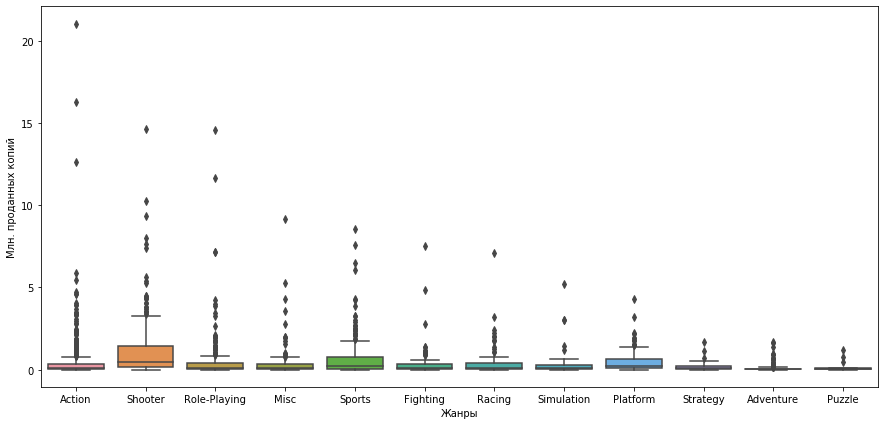

In [30]:
plt.figure(figsize=(15, 7))
boxplot = sns.boxplot(x = actual_games['genre'], y = actual_games['sum_sales'].sort_values(ascending = False));
plt.ylabel('Млн. проданных копий')
plt.xlabel('Жанры')

**Вывод:** в расчёте на единицу игры самыми продаваемыми являются следующие жанры: шутеры, спортивные и платформеры, а ролевые и экшн-игры продаются в 2-3 раза хуже. Однако стоит заметить, что для жанров экшн, шутеров и ролевых игр есть значительное количество бестсцеллеров (выбросы по боксплоту)

## Портрет пользователя каждого региона. 

In [31]:
#функция для составления портрета:
def portrait(region):
    platform = actual_games.pivot_table(index = 'platform', values = region, aggfunc = 'sum')
    print('Анализ популярности платформ в', region)
    print(platform.sort_values(by = region, ascending = False).head())
    platform.sort_values(by = region ,ascending = False).plot(grid = True, style = 'o', figsize = (15, 10), kind= 'bar', subplots = True)
    plt.title('Количество проданных копий по платформам')
    plt.ylabel('Млн. проданных копий')
    plt.xlabel('Платформы')
    plt.show()
    genre = actual_games.pivot_table(index = 'genre', values = region, aggfunc = 'sum')
    print('Анализ по жанрам в', region)
    print(genre.sort_values(by = region, ascending = False).head())
    genre.sort_values(by = region ,ascending = False).plot(grid = True, style = 'o', figsize = (15, 10), kind= 'bar', subplots = True)
    plt.title('Количество проданных копий по жанрам')
    plt.ylabel('Млн. проданных копий')
    plt.xlabel('Жанры')
    plt.show()
    ESRB = actual_games.pivot_table(index = 'rating', values = region, aggfunc = 'sum')
    print('Анализ по возрастному рейтингу', region)
    print(ESRB.sort_values(by = region, ascending = False))
    ESRB.sort_values(by = region ,ascending = False).plot(grid = True, style = 'o', figsize = (15, 10), kind= 'bar', subplots = True)
    plt.title('Количество проданных копий по возрастному рейтингу')
    plt.ylabel('Млн. проданных копий')
    plt.xlabel('Возрастной рейтинг')
    plt.show()

### Портрет для EU региона

Анализ популярности платформ в eu_sales
          eu_sales
platform          
PS4         141.09
PS3          67.81
XOne         51.59
X360         42.52
3DS          30.96


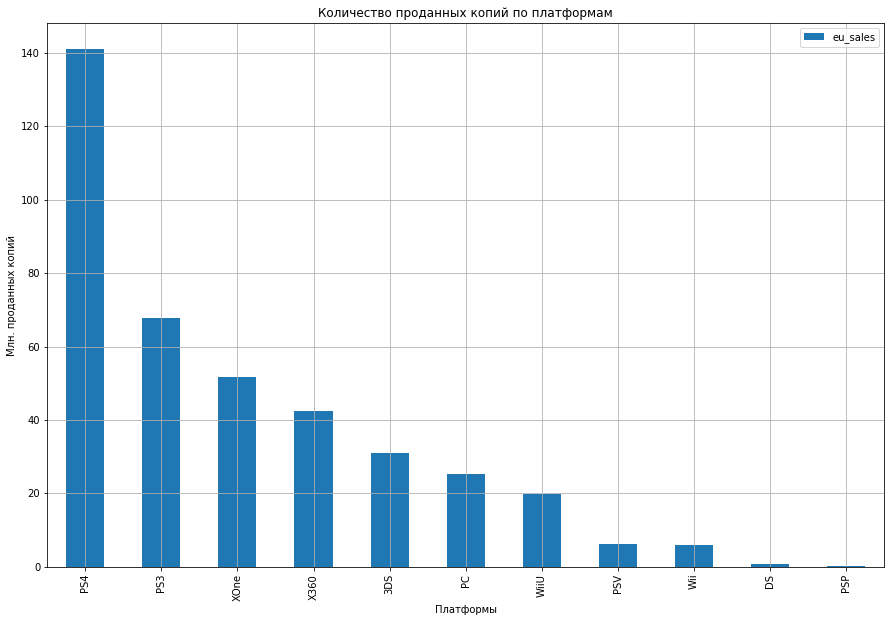

Анализ по жанрам в eu_sales
              eu_sales
genre                 
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19


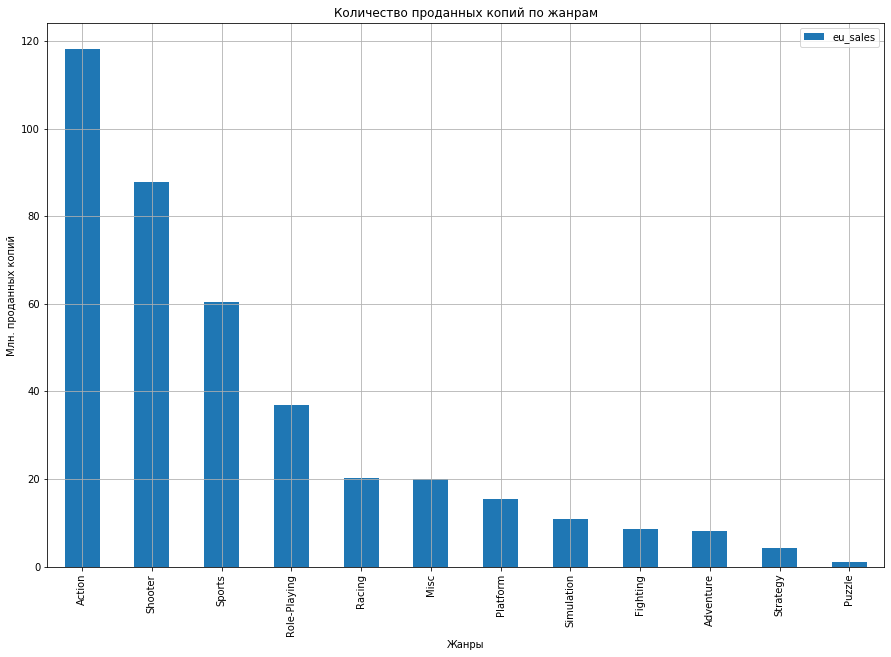

Анализ по возрастному рейтингу eu_sales
        eu_sales
rating          
M         145.32
E          83.36
RP         78.91
E10+       42.69
T          41.95


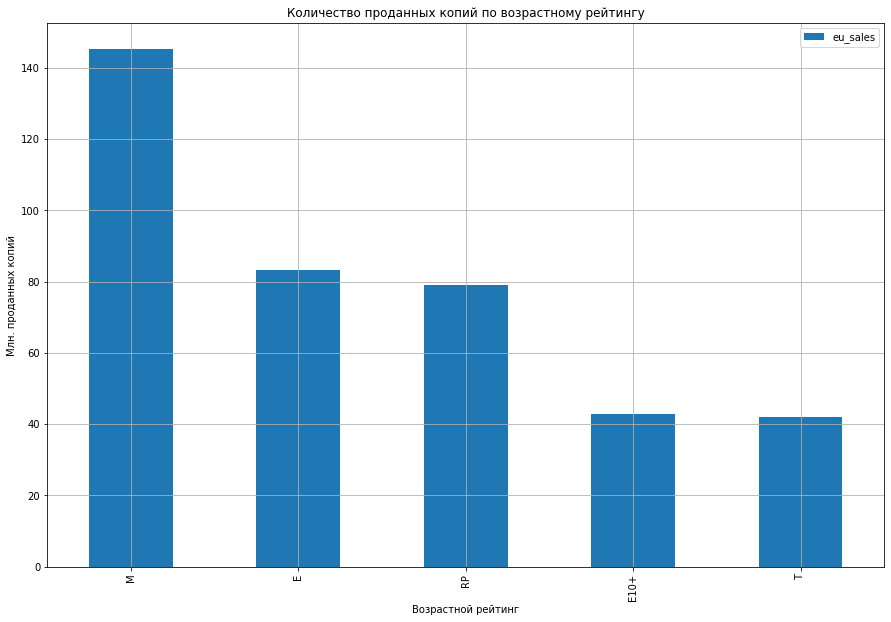

In [32]:
portrait('eu_sales')

**Вывод:** пользователи в Европе больше предпочитают Play Station 4,3, XOne, Xbox 360. Любят жанры экшн, шутеры, симуляторы спорта. Лидируют игры с рейтингами для взрослых, но различия связаны скорее с малым количеством игр с рейтингом 10+ и для подростков

### Портрет для NA региона

Анализ популярности платформ в na_sales
          na_sales
platform          
PS4         108.74
XOne         93.12
X360         81.66
PS3          63.50
3DS          38.20


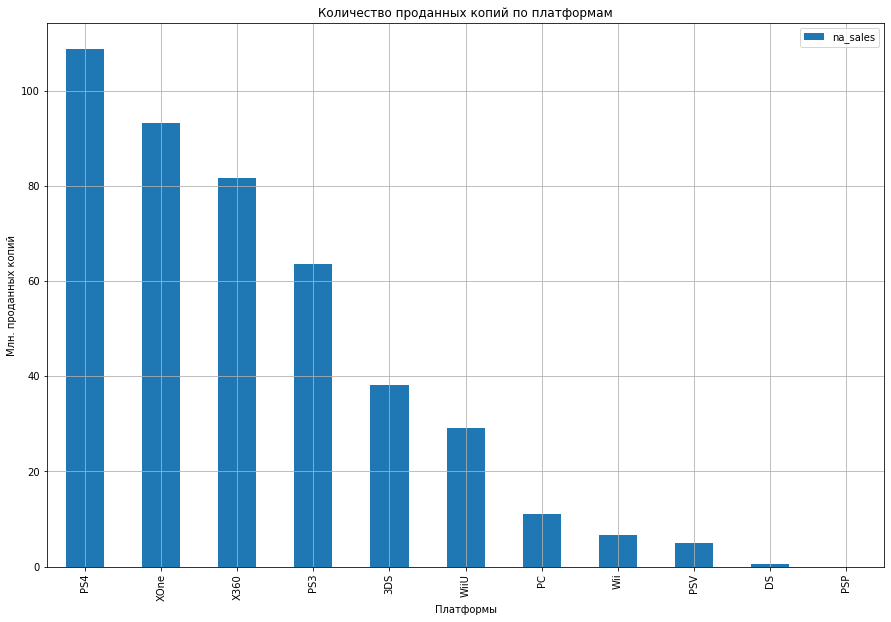

Анализ по жанрам в na_sales
              na_sales
genre                 
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49


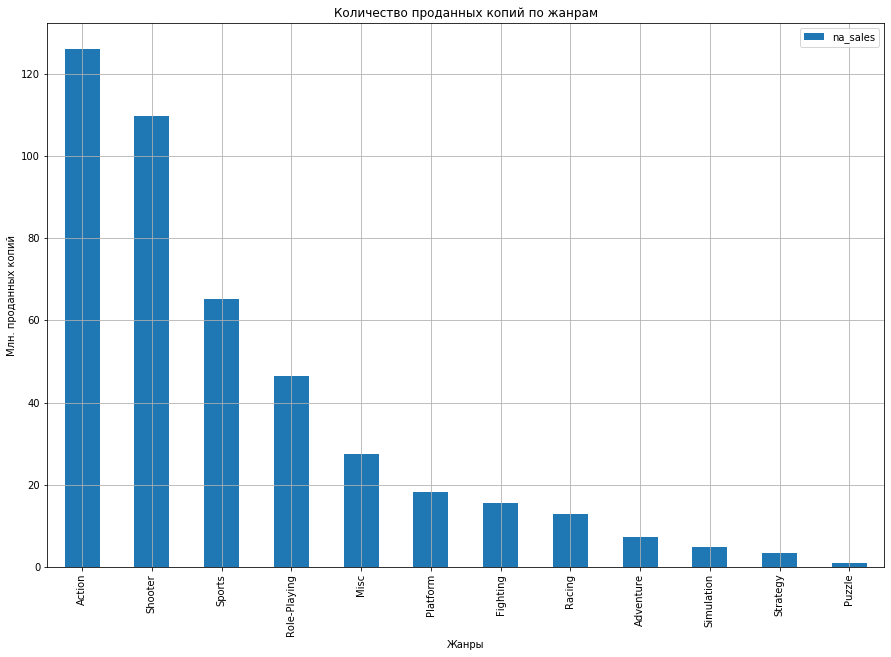

Анализ по возрастному рейтингу na_sales
        na_sales
rating          
M         165.21
RP         89.42
E          79.05
E10+       54.24
T          49.79


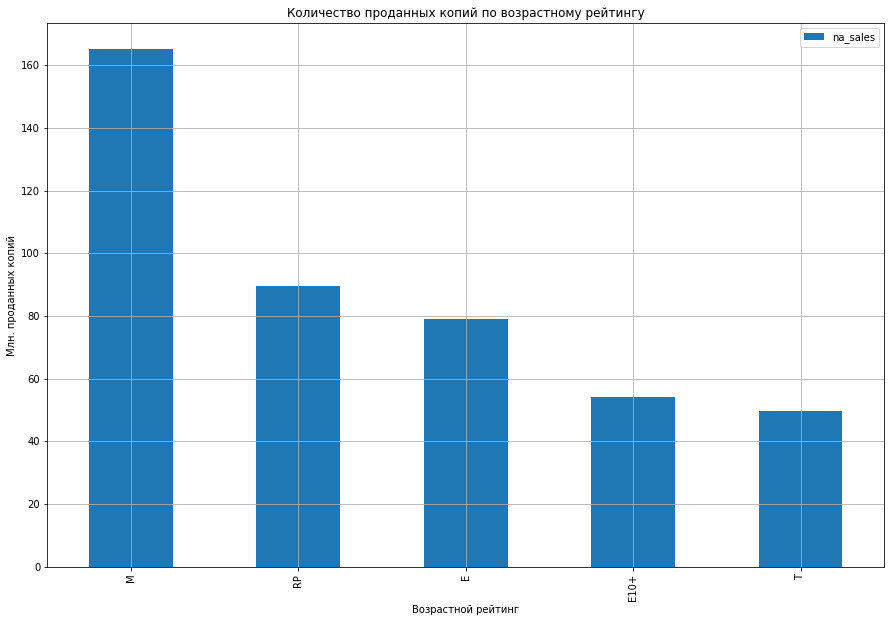

In [33]:
portrait('na_sales')

**Вывод:** пользователи в Северной Америке больше предпочитают Play Station, XOne, Xbox 360, PS3. Любят жанры экшн, шутеры, симуляторы спорта. Лидируют игры с рейтингами для взрослых, но различия связаны скорее с малым количеством игр с рейтингом 10+ и для подростков

### Портрет для JP региона

Анализ популярности платформ в jp_sales
          jp_sales
platform          
3DS          67.81
PS3          23.35
PSV          18.59
PS4          15.96
WiiU         10.88


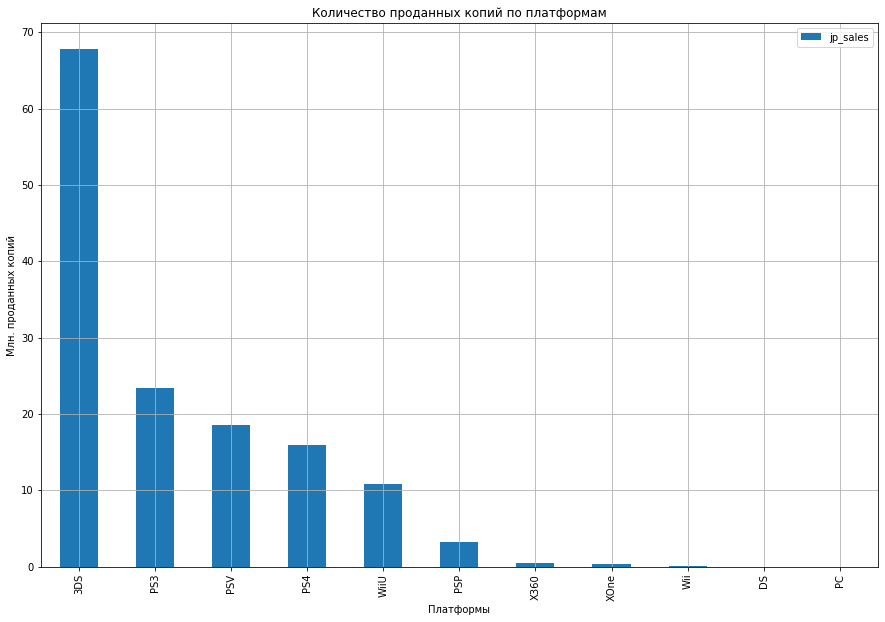

Анализ по жанрам в jp_sales
              jp_sales
genre                 
Role-Playing     51.04
Action           40.49
Misc              9.20
Fighting          7.65
Shooter           6.61


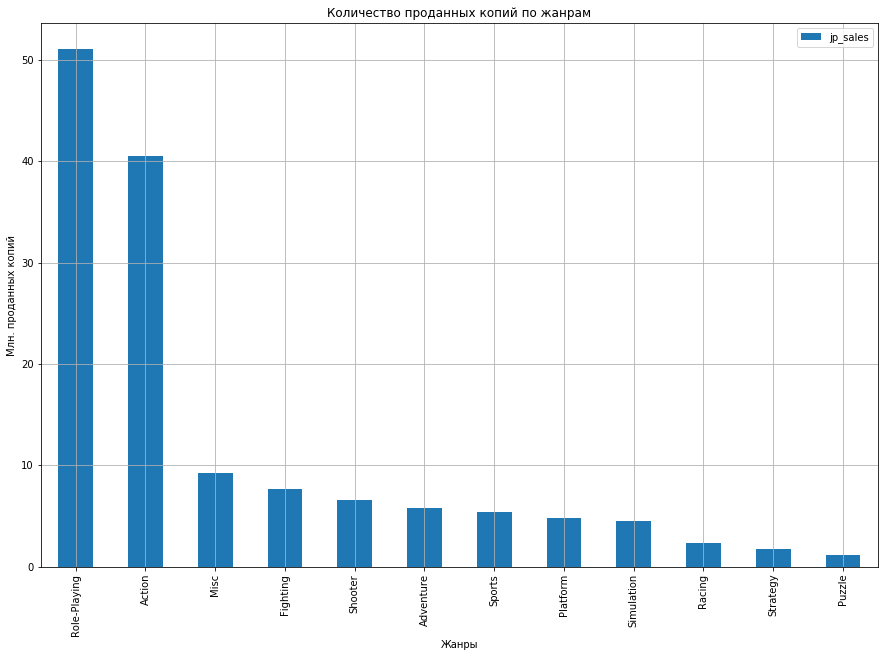

Анализ по возрастному рейтингу jp_sales
        jp_sales
rating          
RP         85.05
T          20.59
E          15.14
M          14.11
E10+        5.89


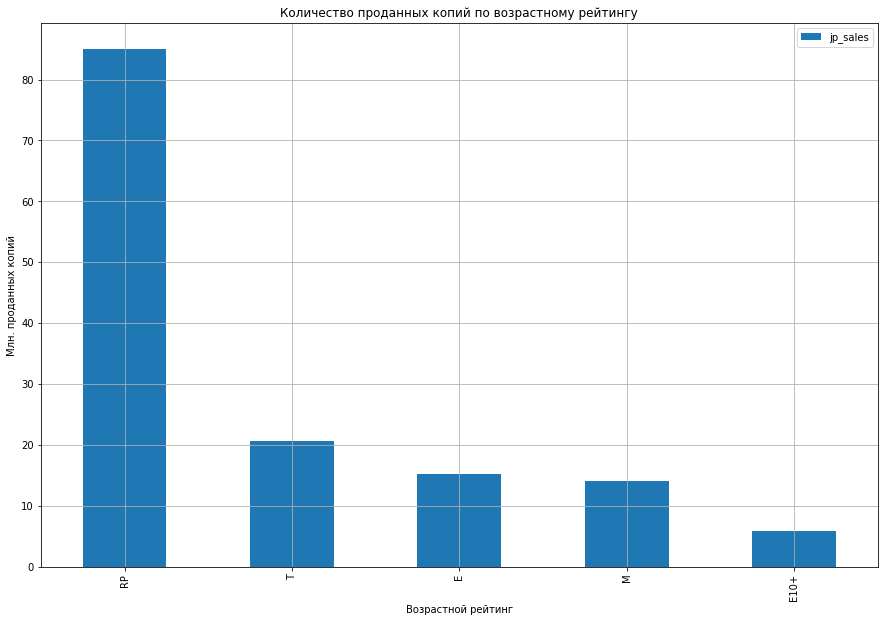

In [34]:
portrait('jp_sales')

**Вывод:** пользователи в Японии фанаты нинтендо и приставок Play Station (включаю PSVita), при этом XBox не пользуется популярностью. Любят ролевые игры и экшн (связанно с направленностью геймдева региона). Игры для взрослых не особо в ходу, высокий процент игр без рейтинга связан с другой рейтинговой системой региона.

**Общий вывод:** портреты пользователей Европы и Северной Америки схожи по всем параметрам в отличие от Японии, где преобладают японские консоли и ролевые игры со своей системой рейтинга

[Вернуться к содержанию](#back-bullet)

<a id='hypothesis-bullet'></a>

## 5. Формулировка и проверка гипотез

Для проверки сформулированы следующие гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Но: среднее одной совокупности равно среднему другой с вероятностью 95%. Н1: соответственно не равно.

In [35]:
actual_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16709
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       2233 non-null object
user_score         2233 non-null object
rating             2233 non-null object
sum_sales          2233 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 306.8+ KB


In [36]:
actual_games[(actual_games['platform'] == 'XOne') & (~(actual_games['user_score'].isin(['w/r']))) & (~(actual_games['critic_score'].isin(['w/r'])))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81,5.4,M,5.26
242,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84,6.4,T,4.49
270,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88,6.2,M,4.22
373,Assassin's Creed: Unity,XOne,2014,Action,2.27,0.90,0.00,0.33,72,4.1,M,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
16592,Saints Row: Gat out of Hell,XOne,2015,Action,0.00,0.01,0.00,0.00,65,6,M,0.01
16625,Sébastien Loeb Rally Evo,XOne,2016,Racing,0.00,0.01,0.00,0.00,63,8.2,E,0.01
16638,Rugby Challenge 3,XOne,2016,Sports,0.00,0.01,0.00,0.00,64,6.6,E,0.01
16640,ZombiU,XOne,2016,Action,0.00,0.01,0.00,0.00,77,7.7,RP,0.01


In [37]:
from scipy import stats as st
alpha = 0.05
results = st.ttest_ind(actual_games[(actual_games['platform'] == 'XOne') & (~(actual_games['user_score'].isin(['w/r'])))]['user_score'], actual_games[(actual_games['platform'] == 'PC') & (~(actual_games['user_score'].isin(['w/r'])))]['user_score'], equal_var = False)

if results.pvalue < 0.05:
    print('Отвергам нулевую гипотезу, средние рейтинги не равны', results.pvalue)
else:
    print('Не отвергаем нулевую гипотезу, средние рейтинги равны', results.pvalue)

Отвергам нулевую гипотезу, средние рейтинги не равны 0.04428738954548199


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Но: среднее одной совокупности равно среднему другой с вероятностью 95%. Н1: соответственно не равно.

In [38]:
alpha = 0.05
selection_1 = actual_games[(actual_games['genre'] == 'Action') & (~(actual_games['user_score'].isin(['w/r'])))]['user_score']
selection_2 = actual_games[(actual_games['genre'] == 'Sports') & (~(actual_games['user_score'].isin(['w/r'])))]['user_score']
results = st.ttest_ind(selection_1, selection_2, equal_var = False)

if results.pvalue < 0.05:
    print('Отвергам нулевую гипотезу, средние рейтинги не равны', results.pvalue)
else:
    print('Не отвергаем нулевую гипотезу, средние рейтинги равны', results.pvalue)

Отвергам нулевую гипотезу, средние рейтинги не равны 3.99932035993735e-25


[Вернуться к содержанию](#back-bullet)

<a id='conclusion-bullet'></a>

## 5. Заключение
Проведен анализ данных по продажам игр с 1980 по 2016 год и выведены следующие закономерности: 

ПК - долгожитель среди платформ. Это связано с тем, что можно бесконечно обновлять железо, при этом ПК так и останется ПК, что является одним из его преимуществ. С консолями так не получится, поэтому с выходом нового поколения старые модели морально устаривают и прекращают использоваться. Также можно увидеть платформы которые не выстрелили: TG16, PCFX и GG. Благодаря найденным закономерностям,  можно спрогнозировать, что в 2017 году на рынке будут популярны ХOne,PS4 и ПК.

В зависимости от региона можно сделать прогноз о популярности платформ: в Европе и Америке предпочитают XBox, PS, в Японии тяготеют к родным консолям. 

Рейтинги (в основном на рынке предпочитают игры категории Для взрослых), оценки пользователей и критиков слабо влияют на продажи (было бы интересно посмотреть на рекламные расходы на игру и вывести зависимость от продаж).

Самые популярные жанры в мире: экшн и шутеры, на что стоит обратить внимание разрботчикам игр. При этом на западе также любят спортивные симуляторы, а в японии наибольшей популярностью пользуются ролевые игры. Выбор жанров вероятно связан с процессом игры в реальном времени, что в свою очередь даёт наибольшие вовлеченность в процесс и эмоции. При этом в расчёте на единицу игры самыми продаваемыми являются следующие жанры: шутеры, спортивные и платформеры, а ролевые и экшн-игры продаются в 2-3 раза хуже. Однако стоит заметить, что для жанров экшн, шутеров и ролевых игр есть значительное количество бестсцеллеров (выбросы по боксплоту).